In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
from pooch import retrieve as download

# this makes sure we can import `gcb_ocean_python.validation_sfco2_socat`
sys.path.insert(0, '../gcb_ocean_python/')

# stop warnings from displaying when importing this package
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.prop_cycle'] = plt.style.library['fivethirtyeight']['axes.prop_cycle']

# note that socat validation is a standalone package and can be copied around without 
# any other python files required (appart from dependencies)
import evaluation_sfco2_socat as gcb_eval
import viz  # allows us to quickly plot maps (not standalone)

# gcb_eval automatically sets YEAR_END to [current year - 1]
# we can change this after the script has been loaded as shown below
gcb_eval.YEAR_END = 2021

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The function's documentation

In [23]:
help(gcb_eval.evaluate_sfco2)

Help on function evaluate_sfco2 in module evaluation_sfco2_socat:

evaluate_sfco2(sfco2, region='all', method='annual', cache_dir='/Users/luke/Git/GCB-Ocean-scripts/data_cache/', log_level=20)
    Evaluates predicted sfco2 against SOCATv202X sfCO2
    
    Note 
    ----
    You will have to apply a mask to the input data to ensure 
    that all models and pCO2-products are compared fairly since
    not all products have the same coverage. This can heavily 
    influence the results since marginal regions that are not 
    covered by all methods often have the largest variability 
    and thus uncertainty. 
    
    Parameters
    ----------
    sfco2 : [np.ndarray, xr.DataArray]
        Must be a 3-dimensional array [time, lat, lon] with 
        lat = [-90, 90], lon = [-180, 180]. Assumed that time ends
        on 202X-12-15 (set in global options)
    method : str, optional
        'monthly' or 'annual', by default 'annual'
        'annual' compares the spatially-averaged time serie

# Running the function

You'll notice that there are two methods: `annual` and `monthly`

The first is how GCB calculates RMSE, while the second is how Gregor et al. (2019) calculate RMSE. 

In [24]:
# the path to the zenodo repository
url = 'https://zenodo.org/record/7273309/files/GCB-2022_dataprod_LDEO-HPD_1982-2021.nc?download=1'
fname = gcb_eval.download(url, dest_path='./data_cache/')
sfco2 = xr.open_dataset(fname).sfco2

In [25]:
sfco2 = sfco2.sel(time=slice('1990', '2021'))

In [26]:
rmse_annual = gcb_eval.evaluate_sfco2(sfco2, region='all', method='annual', log_level=20)

[GCB-2023: 2023-07-11 13:20:24] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:24] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:24] Input sfco2 is within expected range [0, 1000] - [241.89, 477.18]. 

[GCB-2023: 2023-07-11 13:20:25] Comparing sfco2 against SOCATv2023 for region GLOBAL
[GCB-2023: 2023-07-11 13:20:25] Calculating statistics for region: GLOBAL
[GCB-2023: 2023-07-11 13:20:26] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:26] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:26] Using annual time-series-based RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt

[GCB-2023: 2023-07-11 13:20:26] Comparing sfco2 against SOCATv2023 for region NORTH
[GCB-2023: 2023-07-11 13:20:26] Calculating statistics for region: NORTH
[GCB-2023: 2023-07-11 13

In [27]:
# log_level=10 is is very verbose; default is 20; for quiet operation, set to 30
rmse_monthly = gcb_eval.evaluate_sfco2(sfco2, region='all', method='monthly', log_level=30) 

[GCB-2023: 2023-07-11 13:20:31] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:31] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:32] Input sfco2 is within expected range [0, 1000] - [241.89, 477.18]. 

[GCB-2023: 2023-07-11 13:20:32] Comparing sfco2 against SOCATv2023 for region GLOBAL
[GCB-2023: 2023-07-11 13:20:33] Calculating statistics for region: GLOBAL
[GCB-2023: 2023-07-11 13:20:34] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:34] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:34] Using monthly point-wise RMSE method: (fco2 - socat) -> resid[time,lat,lon] -> square(resid) -> mean(lat, lon) -> annual_mean -> sqrt -> mean

[GCB-2023: 2023-07-11 13:20:34] Comparing sfco2 against SOCATv2023 for region NORTH
[GCB-2023: 2023-07-11 13:20:34] Calculating statistics for region: NORTH
[GCB-2023: 2023-07-11 13:20:35] Converted 

# Difference between the two methods

### Annual approach (time-series comparison)

1. subsample data points for where there are obs (automatically done)
2. average over lon and lat
1. calculate annual mean
1. take out any point where model or data are NaNs (no need)
1. detrend both time-series (model, socat)
1. calculate rmse (using square root of the averaged square of residuals)

### Monthly approach (point-wise comparison)

1. difference between the model and target data = residuals
1. square the resudials
1. average over lat and lon
1. resample to annual mean
1. square root of the annual mean
1. average over time (years)

## Summary
The main difference is that ANNUAL comparse aggregated time series, while MONTHLY compares individual points and then aggregates

<AxesSubplot:xlabel='region'>

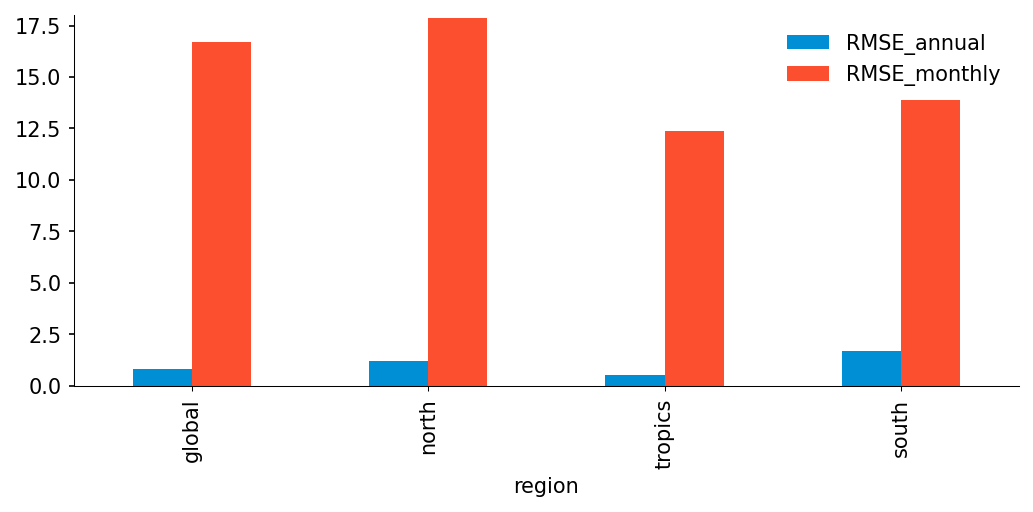

In [37]:
rmse = pd.concat([
    rmse_annual.rmse_avg.to_series().rename('RMSE_annual'),
    rmse_monthly.rmse_avg.to_series().rename('RMSE_monthly'),
], axis=1)

fig, ax = plt.subplots(figsize=[7,3])
rmse.plot.bar(ax=ax)

# Running with model data

In [29]:
url = "https://zenodo.org/record/7273309/files/GCB-2022_OceanModel_Princeton_1959-2021.nc?download=1"
fname = gcb_eval.download(url, dest_path='./data_cache/')
sfco2 = xr.open_dataset(fname).sfco2.sel(simulation='A')

# to select the GCB starting period, simply truncate the input sfco2
sfco2 = sfco2.sel(time=slice('1990', '2021'))

In [30]:
model_rmse = gcb_eval.evaluate_sfco2(sfco2, region='all', method='annual')

[GCB-2023: 2023-07-11 13:20:39] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:39] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:40] Input sfco2 is within expected range [0, 1000] - [203.92, 505.31]. 

[GCB-2023: 2023-07-11 13:20:40] Comparing sfco2 against SOCATv2023 for region GLOBAL
[GCB-2023: 2023-07-11 13:20:41] Calculating statistics for region: GLOBAL
[GCB-2023: 2023-07-11 13:20:42] Converted monthly input to xr.DataArray based on shape (assumed end year = 2021)
[GCB-2023: 2023-07-11 13:20:42] Common time period: 1990-01 - 2021-12
[GCB-2023: 2023-07-11 13:20:42] Using annual time-series-based RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt

[GCB-2023: 2023-07-11 13:20:42] Comparing sfco2 against SOCATv2023 for region NORTH
[GCB-2023: 2023-07-11 13:20:42] Calculating statistics for region: NORTH
[GCB-2023: 2023-07-11 13

Text(0.5, 0, '')

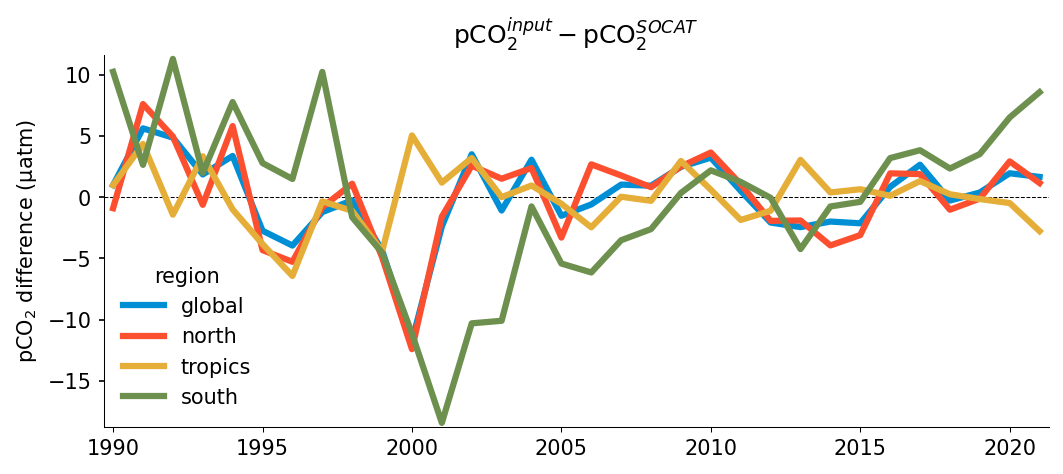

In [39]:
fig, ax = plt.subplots(figsize=[7,3])

ax.axhline(0, color='k', linestyle='--', lw=0.5)
model_rmse.residuals.plot(ax=ax, hue='region', lw=3)

ax.set_title('pCO$_2^{input} - $pCO$_2^{SOCAT}$')
ax.set_ylabel('pCO$_2$ difference (µatm)')
ax.set_xlabel('')

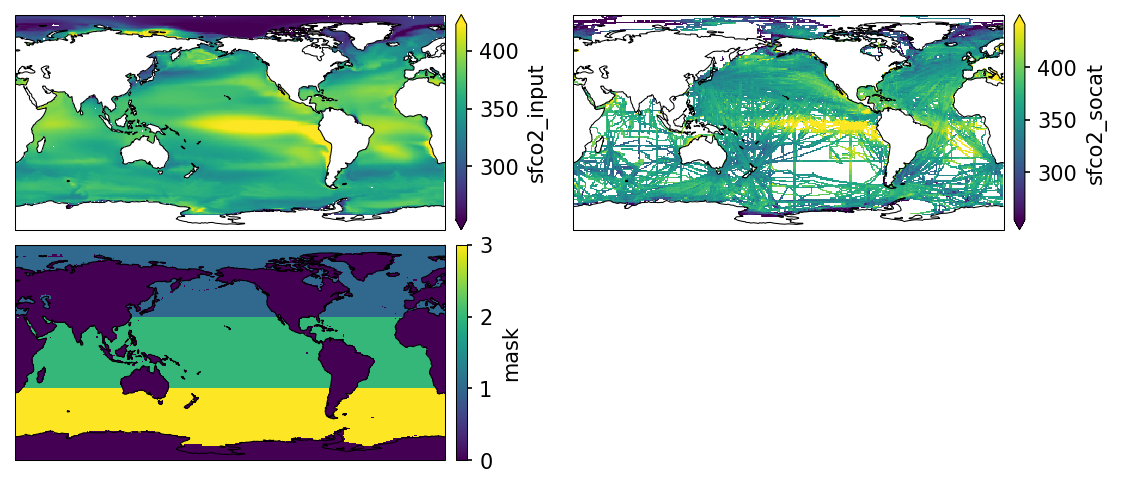

In [43]:
plt.figure(figsize=[8, 3.6])
model_rmse.sfco2_input.mean('time').geo(pos=221)
model_rmse.sfco2_socat.mean('time').geo(pos=222)
model_rmse.mask.geo(pos=223)